# Foreground - Background Color Generation for MNIST

In [ ]:
# 필요 라이브러리 임포트
import torch
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import cv2
from scipy.ndimage import gaussian_filter

In [ ]:
#데이터 전처리 함수 정의

def deskew(image):
    """
    PyTorch 텐서를 입력받아 기울기를 바로잡은 이미지를 반환합니다.
    """
    image = image.squeeze().numpy()  # 텐서를 NumPy 배열로 변환
    moments = cv2.moments(image)  # 이미지 모멘트 계산
    if abs(moments['mu02']) < 1e-2:  # mu02가 거의 0이면 기울어짐이 없다고 판단
        return torch.tensor(image).unsqueeze(0)  # NumPy -> 텐서 변환 후 반환
    skew = moments['mu11'] / moments['mu02']  # 왜곡 계수 계산
    M = np.array([[1, skew, -0.5 * skew * image.shape[0]], [0, 1, 0]], dtype=np.float32)  # 변환 행렬
    deskewed = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return torch.tensor(deskewed).unsqueeze(0)  # NumPy -> 텐서 변환 후 반환

def remove_noise(image):
    """
    PyTorch 텐서를 입력받아 노이즈 제거된 이미지를 반환합니다.
    """
    thresholded = (image > 0.5).float()  # 0.5 이상이면 1, 아니면 0
    return thresholded

# Gaussian Blurring 함수
def apply_blur(image):
    """
    PyTorch 텐서를 입력받아 Gaussian 필터를 적용한 이미지를 반환합니다.
    """
    image = image.squeeze().numpy()  # 텐서를 NumPy 배열로 변환
    blurred = gaussian_filter(image, sigma=1)  # Gaussian 필터 적용
    return torch.tensor(blurred).unsqueeze(0)  # NumPy -> 텐서 변환 후 반환

# 전체 전처리 함수
def preprocess_mnist_image(image):
    """
    MNIST 이미지를 전처리합니다: Deskewing, Noise Removal, Blurring
    """
    image = deskew(image)  # Step 1: Deskewing
    image = remove_noise(image)  # Step 2: Noise Removal
    image = apply_blur(image)  # Step 3: Blurring
    return image


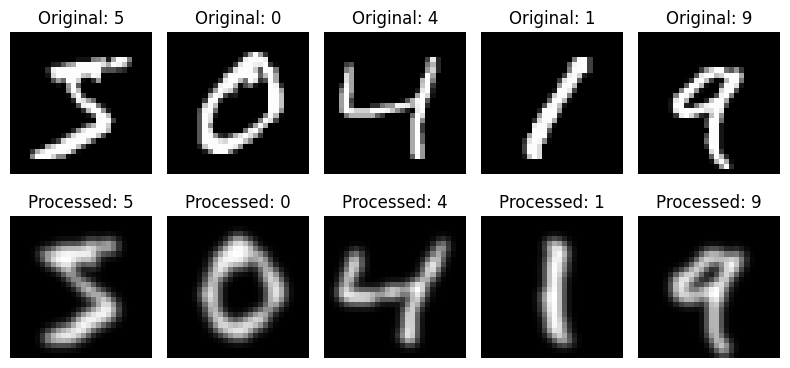

In [ ]:
# 데이터셋 전처리 함수
def preprocess_dataset(dataset):
    processed_dataset = []
    for image, label in dataset:
        processed_image = preprocess_mnist_image(image)  # 전처리 함수 적용
        processed_dataset.append((processed_image, label))
    return processed_dataset

# Transform 정의 및 데이터셋 로드
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 학습 데이터셋 전처리
processed_mnist = preprocess_dataset(mnist)

# 전처리 결과 시각화
def visualize_preprocessing(original, processed):
    plt.figure(figsize=(8, 4))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(original[i][0].squeeze().numpy(), cmap="gray")
        plt.title(f"Original: {original[i][1]}")
        plt.axis("off")

        plt.subplot(2, 5, i + 6)
        plt.imshow(processed[i][0].squeeze().numpy(), cmap="gray")
        plt.title(f"Processed: {processed[i][1]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# 원본과 전처리된 데이터 비교 시각화
visualize_preprocessing(mnist, processed_mnist)

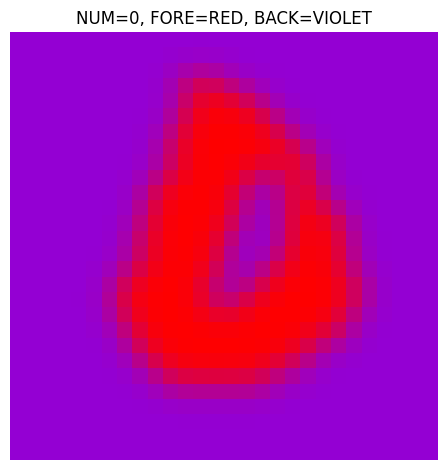

In [ ]:
# 무지개 색상 팔레트를 정의합니다 (7가지 색상).
RAINBOW_COLORS = [
    (255, 0, 0),    # 빨강
    (255, 127, 0),  # 주황
    (255, 255, 0),  # 노랑
    (0, 255, 0),    # 초록
    (0, 0, 255),    # 파랑
    (75, 0, 130),   # 남색 (인디고)
    (148, 0, 211)   # 보라
]

RAINBOW_NAMES = [
    'RED',
    'ORANGE',
    'YELLOW',
    'GREEN',
    'BLUE',
    'INDIGO',
    'VIOLET'
]

def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 색상을 선택합니다."""
    # return tuple(np.random.randint(0, 256, size=3))
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 전경(fg)과 배경(bg) 색상을 적용합니다."""
    digit = digit_image.convert('L')  # 이미지를 그레이스케일로 변환합니다.
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGBA')
    return colored_digit

def overlay_digit_on_background(colored_digit):
    """투명도를 제거하고 일관된 배경 이미지를 생성합니다."""
    final_image = colored_digit.convert('RGB')  # 투명도를 제거합니다.
    return final_image

# 전경과 배경 색상이 있는 MNIST 데이터셋을 생성하고 표시합니다.
idx = np.random.randint(0, len(processed_mnist))  # 0~9 사이의 숫자
image, label = processed_mnist[idx]
pil_image = transforms.ToPILImage()(image)

# 전경과 배경 색상을 무작위로 선택합니다.
fg_color, fg_label = get_random_rainbow_color()
bg_color, bg_label = get_random_rainbow_color()

# 전경과 배경 색상이 같지 않도록 보장합니다.
while bg_color == fg_color:
  bg_color, bg_label = get_random_rainbow_color()

# 선택된 색상으로 숫자 이미지를 색칠합니다.
colored_digit = colorize_digit(pil_image, fg_color, bg_color)

if image is not None:
  # 최종 이미지를 표시합니다.
  final_image = overlay_digit_on_background(colored_digit)
  plt.imshow(final_image)
  plt.axis('off')  # 축을 비활성화합니다.
  plt.title(f'NUM={label}, FORE={fg_label}, BACK={bg_label}')

  # 레이아웃을 조정하고 화면에 표시합니다.
  plt.tight_layout()
  plt.show()


# MNIST Generation using Custom Fonts

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from glob import glob

# 운영체제에 따라 한글 폰트를 설정합니다.
# if os.name == 'posix':
#     plt.rc("font", family="AppleGothic")  # macOS와 같은 POSIX 시스템용
# else:
#     plt.rc("font", family="Malgun Gothic")  # Windows 시스템용

# plt.rc("axes", unicode_minus=False)  # 유니코드 마이너스 기호 사용 설정

# 폰트 경로를 재귀적으로 탐색하여 모든 ttf 폰트 파일을 가져옵니다.
FONT_PATHS = glob('./fonts/**/*.ttf', recursive=True)

# MNIST와 유사한 이미지 크기와 폰트 크기 설정
IMAGE_SIZE = (28, 28)  # 이미지 크기 (28x28)
FONT_SIZE = 22  # 폰트 크기

def generate_digit_image(digit, font_path):
    """ 주어진 폰트로 특정 숫자 이미지를 생성하는 함수 """
    # 흰 배경의 이미지를 생성합니다.
    image = Image.new("L", IMAGE_SIZE, 255)  # 흰 배경 이미지 (L 모드는 그레이스케일)
    draw = ImageDraw.Draw(image)  # 이미지를 그리기 위한 객체 생성

    try:
        # 지정된 경로에서 폰트를 불러옵니다.
        font = ImageFont.truetype(font_path, FONT_SIZE)
    except IOError:
        # 폰트를 불러올 수 없는 경우 오류 메시지 출력
        print(f"폰트를 불러올 수 없습니다: {font_path}")
        return None

    # 텍스트(숫자)의 경계 상자를 계산합니다.
    bbox = draw.textbbox((0, 0), str(digit), font=font)
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

    # 텍스트를 이미지의 중앙에 배치합니다.
    # position = ((IMAGE_SIZE[0] - text_width) // 2, (IMAGE_SIZE[1] - text_height) // 2)
    position = ((IMAGE_SIZE[0] - text_width) // 2, 0)  # 위쪽에 정렬

    # 검은색(값 0)으로 숫자를 이미지에 그립니다.
    draw.text(position, str(digit), fill=0, font=font)

    return np.array(image)  # 생성된 이미지를 넘파이 배열로 반환

# 0에서 9 사이의 랜덤 숫자를 생성합니다.
digit = np.random.randint(0, 10)

# 폰트 경로 리스트에서 랜덤하게 하나의 폰트를 선택합니다.
font_path = random.choice(FONT_PATHS)

# 선택된 폰트로 숫자 이미지를 생성합니다.
image = generate_digit_image(digit, font_path)

if image is not None:
    # 이미지 파일로 저장하는 부분 (주석 처리됨)
    # image_filename = os.path.join(output_dir, f"{digit}_{i}.png")
    # Image.fromarray(image).save(image_filename)

    # 생성된 이미지를 화면에 표시합니다.
    plt.imshow(1 - image, cmap='gray')  # 이미지를 반전하여 검정색으로 보이게 설정
    plt.axis('off')  # 축 비활성화
    plt.title(f"NUM={digit}, FONT={font_path.split('/')[-1]}")  # 제목에 숫자와 폰트명 표시

    # 레이아웃을 조정하고 이미지를 표시합니다.
    plt.tight_layout()
    plt.show()


IndexError: list index out of range

IndexError: list index out of range

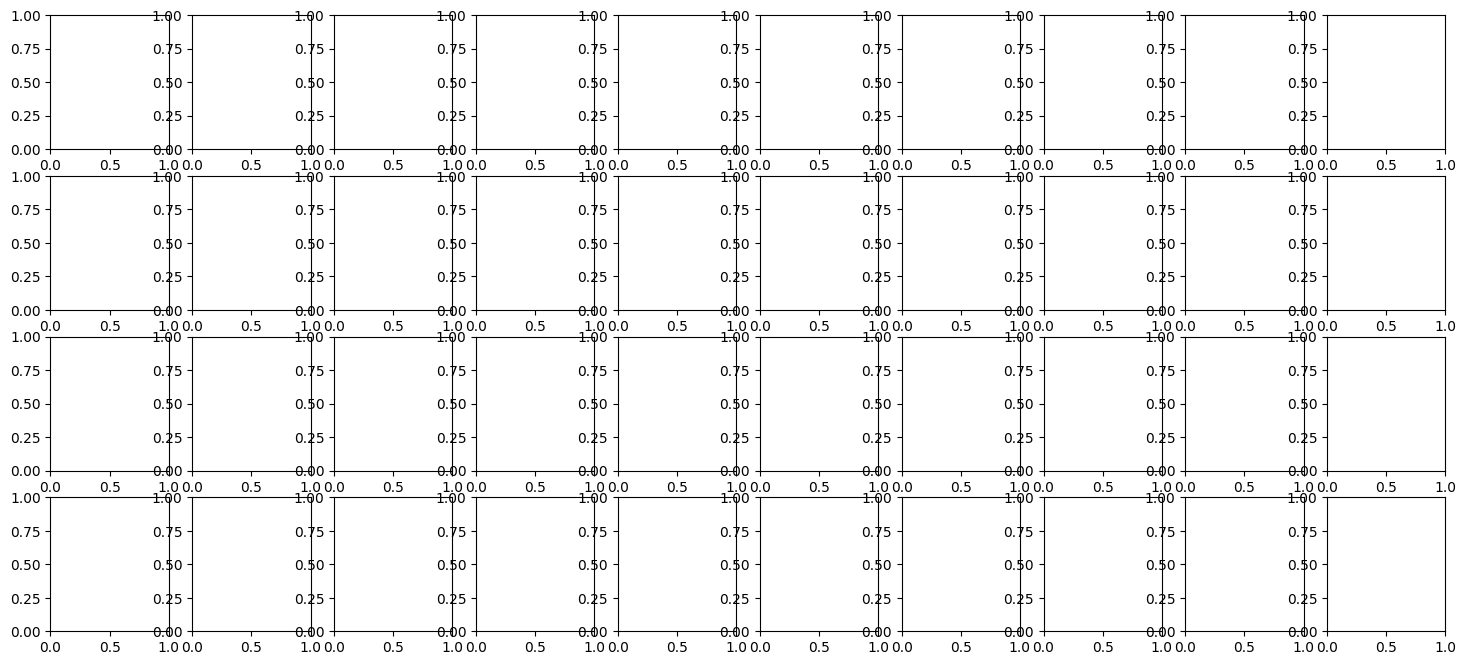

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from glob import glob

# 운영체제에 따라 한글 폰트를 설정합니다.
# if os.name == 'posix':
#     plt.rc("font", family="AppleGothic")  # macOS와 같은 POSIX 시스템용
# else:
#     plt.rc("font", family="Malgun Gothic")  # Windows 시스템용

# plt.rc("axes", unicode_minus=False)  # 유니코드 마이너스 기호 사용 설정

# 폰트 경로를 재귀적으로 탐색하여 모든 ttf 폰트 파일을 가져옵니다.
FONT_PATHS = glob('./fonts/**/*.ttf', recursive=True)

# MNIST와 유사한 이미지 크기와 폰트 크기 설정
IMAGE_SIZE = (28, 28)  # 이미지 크기 (28x28)
FONT_SIZE = 22  # 폰트 크기

def generate_digit_image(digit, font_path):
    """ 주어진 폰트로 특정 숫자 이미지를 생성하는 함수 """
    # 흰 배경의 이미지를 생성합니다.
    image = Image.new("L", IMAGE_SIZE, 255)  # 흰 배경 이미지 (L 모드는 그레이스케일)
    draw = ImageDraw.Draw(image)  # 이미지를 그리기 위한 객체 생성

    try:
        # 지정된 경로에서 폰트를 불러옵니다.
        font = ImageFont.truetype(font_path, FONT_SIZE)
    except IOError:
        # 폰트를 불러올 수 없는 경우 오류 메시지 출력
        print(f"폰트를 불러올 수 없습니다: {font_path}")
        return None

    # 텍스트(숫자)의 경계 상자를 계산합니다.
    bbox = draw.textbbox((0, 0), str(digit), font=font)
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

    # 텍스트를 이미지의 중앙에 배치합니다.
    # position = ((IMAGE_SIZE[0] - text_width) // 2, (IMAGE_SIZE[1] - text_height) // 2)
    position = ((IMAGE_SIZE[0] - text_width) // 2, 0)  # 위쪽에 정렬

    # 검은색(값 0)으로 숫자를 이미지에 그립니다.
    draw.text(position, str(digit), fill=0, font=font)

    return np.array(image)  # 생성된 이미지를 넘파이 배열로 반환



# 전경과 배경 색상이 있는 MNIST 데이터셋을 생성하고 표시합니다.
fig, axes = plt.subplots(4, 10, figsize=(18, 8))  # 4개의 도메인(행)을 생성합니다.

for row in range(4):  # 4개의 도메인(행)에 대해 반복합니다.
    for col in range(10):  # 0부터 9까지의 숫자를 표시합니다.

        # 0에서 9 사이의 랜덤 숫자를 생성합니다.
        digit = np.random.randint(0, 10)

        # 폰트 경로 리스트에서 랜덤하게 하나의 폰트를 선택합니다.
        font_path = random.choice(FONT_PATHS)

        # 선택된 폰트로 숫자 이미지를 생성합니다.
        image = generate_digit_image(digit, font_path)

        axes[row, col].imshow(1 - image, cmap='gray')
        axes[row, col].axis('off')  # 축을 비활성화합니다.

# 레이아웃을 조정하고 화면에 표시합니다.
plt.tight_layout()
plt.show()



# # 0에서 9 사이의 랜덤 숫자를 생성합니다.
# digit = np.random.randint(0, 10)

# # 폰트 경로 리스트에서 랜덤하게 하나의 폰트를 선택합니다.
# font_path = random.choice(FONT_PATHS)

# # 선택된 폰트로 숫자 이미지를 생성합니다.
# image = generate_digit_image(digit, font_path)

# if image is not None:
#     # 이미지 파일로 저장하는 부분 (주석 처리됨)
#     # image_filename = os.path.join(output_dir, f"{digit}_{i}.png")
#     # Image.fromarray(image).save(image_filename)

#     # 생성된 이미지를 화면에 표시합니다.
#     plt.imshow(1 - image, cmap='gray')  # 이미지를 반전하여 검정색으로 보이게 설정
#     plt.axis('off')  # 축 비활성화
#     plt.title(f"NUM={digit}, FONT={font_path.split('/')[-1]}")  # 제목에 숫자와 폰트명 표시

#     # 레이아웃을 조정하고 이미지를 표시합니다.
#     plt.tight_layout()
#     plt.show()


In [ ]:
X_color = []
y_bg = []
y_fg = []
y_digit = []

def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 색상을 선택합니다."""
    # return tuple(np.random.randint(0, 256, size=3))
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 전경(fg)과 배경(bg) 색상을 적용합니다."""
    digit = digit_image.convert('L')  # 이미지를 그레이스케일로 변환합니다.
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGB')
    return colored_digit

for i in range(len(processed_mnist)):
    image, label = processed_mnist[i]
    pil_image = transforms.ToPILImage()(image)

    # 전경과 배경 색상을 무작위로 선택합니다.
    fg_color, fg_label = get_random_rainbow_color()
    bg_color, bg_label = get_random_rainbow_color()

    # 전경과 배경 색상이 같지 않도록 보장합니다.
    while bg_color == fg_color:
        bg_color, bg_label = get_random_rainbow_color()

    # 전경 및 배경 색상이 적용된 숫자 이미지를 생성합니다.
    colored_digit = colorize_digit(pil_image, fg_color, bg_color)

    # 결과 이미지를 numpy 배열로 변환하고 리스트에 추가합니다.
    X_color.append(np.array(colored_digit))
    y_digit.append(label)
    y_fg.append(fg_label)
    y_bg.append(bg_label)

#리스트를 Numpy로 변환
X_color = np.array(X_color)
y_digit = np.array(y_digit)
y_fg = np.array(y_fg)
y_bg = np.array(y_bg)

# 데이터 형태를 확인합니다.
print(f"X_color.shape: {X_color.shape}")
print(f"y_digit.shape: {y_digit.shape}")
print(f"y_fg.shape: {y_fg.shape}")
print(f"y_bg.shape: {y_bg.shape}")

X_color.shape: (60000, 28, 28, 3)
y_digit.shape: (60000,)
y_fg.shape: (60000,)
y_bg.shape: (60000,)


In [ ]:
# Data Flatten
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# X_color를 (60000, 28, 28, 3)에서 (60000, 2352)로 변환 (flatten)
X_color = np.array(X_color).reshape(-1, 28 * 28 * 3)

# 변환된 X_color_flat의 shape 확인
print(X_color.shape)  # (60000, 2352)

# X_color와 y_fg, y_bg, y_digit에 대한 훈련/검증 세트를 나누기
X_train, X_test = X_color[:50000], X_color[50000:]
y_train_fg, y_test_fg = y_fg[:50000], y_fg[50000:]
y_train_bg, y_test_bg = y_bg[:50000], y_bg[50000:]
y_train_digit, y_test_digit = y_digit[:50000], y_digit[50000:]

# X_train, y_train_fg, y_train_bg, y_train_digit을 한 번에 훈련/검증 세트로 나누기
X_train_split, X_val_split, y_train_fg_split, y_val_fg_split, y_train_bg_split, y_val_bg_split, y_train_digit_split, y_val_digit_split = train_test_split(
    X_train, y_train_fg, y_train_bg, y_train_digit, test_size=0.1, random_state=42
)

(60000, 2352)


In [ ]:
# RandomForest 모델

import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model_fg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_bg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_digit = RandomForestClassifier(n_estimators=100, random_state=42)

# 모델 학습
start_time_fg = time.time()
rf_model_fg.fit(X_train_split, y_train_fg_split)
end_time_fg = time.time()

start_time_bg = time.time()
rf_model_bg.fit(X_train_split, y_train_bg_split)
end_time_bg = time.time()

start_time_digit = time.time()
rf_model_digit.fit(X_train_split, y_train_digit_split)
end_time_digit = time.time()

# 검증 데이터로 예측
start_time_fg_val = time.time()
y_val_fg_pred = rf_model_fg.predict(X_val_split)
end_time_fg_val = time.time()

start_time_bg_val = time.time()
y_val_bg_pred = rf_model_bg.predict(X_val_split)
end_time_bg_val = time.time()

start_time_digit_val = time.time()
y_val_digit_pred = rf_model_digit.predict(X_val_split)
end_time_digit_val = time.time()

training_time_fg = end_time_fg - start_time_fg
training_time_bg = end_time_bg - start_time_bg
training_time_digit = end_time_digit - start_time_digit

training_time_fg_val = end_time_fg_val - start_time_fg_val
training_time_bg_val = end_time_bg_val - start_time_bg_val
training_time_digit_val = end_time_digit_val - start_time_digit_val

accuracy_fg_rf = accuracy_score(y_val_fg_split, y_val_fg_pred)
accuracy_bg_rf = accuracy_score(y_val_bg_split, y_val_bg_pred)
accuracy_digit_rf = accuracy_score(y_val_digit_split, y_val_digit_pred)

print(f"Random Forest 전경 색상(fg) 정확도: {accuracy_fg_rf:.4f}")
print(f"Random Forest 전경 색상(fg) 학습 시간: {training_time_fg:.2f} 초")
print(f"Random Forest Validation 전경 색상(fg) 예측 시간: {training_time_fg_val:.2f} 초")

print(f"Random Forest 배경 색상(bg) 정확도: {accuracy_bg_rf:.4f}")
print(f"Random Forest 배경 색상(bg) 학습 시간: {training_time_bg:.2f} 초")
print(f"Random Forest Validation 배경 색상(bg) 예측 시간: {training_time_bg_val:.2f} 초")

print(f"Random Forest 숫자(digit) 정확도: {accuracy_digit_rf:.4f}")
print(f"Random Forest 숫자(digit) 학습 시간: {training_time_digit:.2f} 초")
print(f"Random Forest Validation 숫자(digit) 예측 시간: {training_time_digit_val:.2f} 초")

Min-Max Scaling
Random Forest 전경 색상(fg) 정확도: 0.9990
Random Forest 전경 색상(fg) 학습 시간: 71.55 초
Random Forest Validation 전경 색상(fg) 예측 시간: 0.16 초
Random Forest 배경 색상(bg) 정확도: 1.0000
Random Forest 배경 색상(bg) 학습 시간: 18.71 초
Random Forest Validation 배경 색상(bg) 예측 시간: 0.08 초
Random Forest 숫자(digit) 정확도: 0.9390
Random Forest 숫자(digit) 학습 시간: 116.87 초
Random Forest Validation 숫자(digit) 예측 시간: 0.34 초


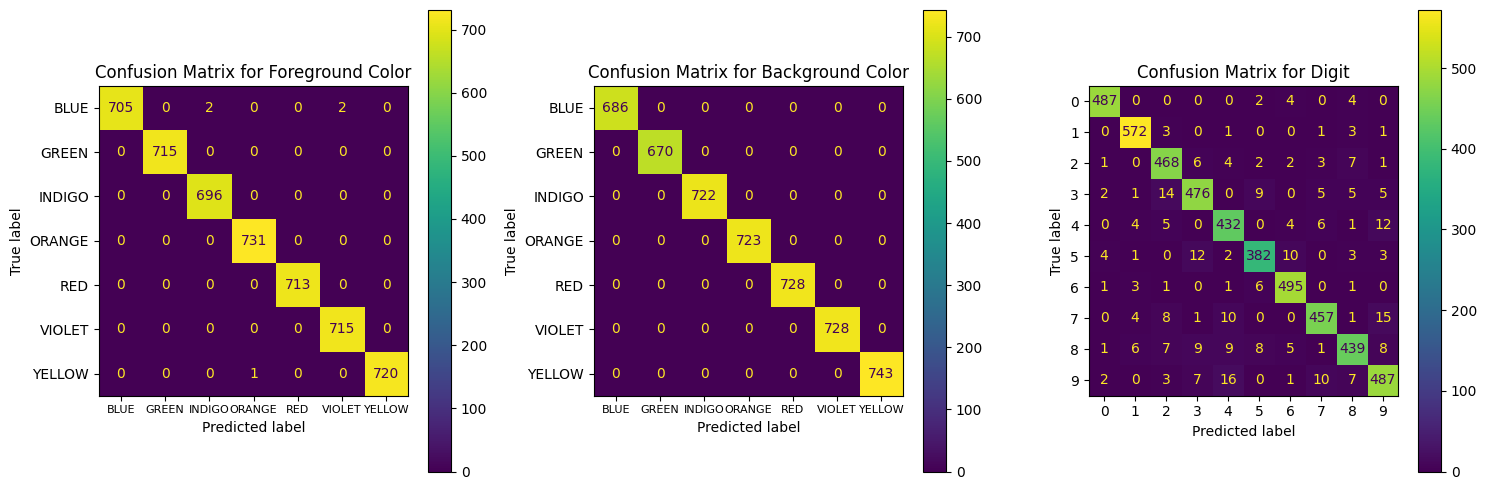

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix 생성
confusion_matrix_fg = confusion_matrix(y_val_fg_split, y_val_fg_pred)
confusion_matrix_bg = confusion_matrix(y_val_bg_split, y_val_bg_pred)
confusion_matrix_digit = confusion_matrix(y_val_digit_split, y_val_digit_pred)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 전경 색상(fg)
cmd_fg = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_fg, display_labels=np.unique(y_val_fg_split))
cmd_fg.plot(ax=axes[0])
axes[0].set_title('Confusion Matrix for Foreground Color')
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=8) # 폰트 사이즈 조절

# 배경 색상(bg)
cmd_bg = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_bg, display_labels=np.unique(y_val_bg_split))
cmd_bg.plot(ax=axes[1])
axes[1].set_title('Confusion Matrix for Background Color')
axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize=8) # 폰트 사이즈 조절

# 숫자(digit)
cmd_digit = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_digit)
cmd_digit.plot(ax=axes[2])
axes[2].set_title('Confusion Matrix for Digit')

# 출력
plt.tight_layout()
plt.show()


In [ ]:
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# SVM 모델 초기화
svm_model_fg = SVC(random_state=42)
svm_model_bg = SVC(random_state=42)
svm_model_digit = SVC(random_state=42)

# 모델 학습 및 시간 측정
start_time_fg = time.time()
svm_model_fg.fit(X_train_split, y_train_fg_split)
train_time_fg = time.time() - start_time_fg

start_time_bg = time.time()
svm_model_bg.fit(X_train_split, y_train_bg_split)
train_time_bg = time.time() - start_time_bg

start_time_digit = time.time()
svm_model_digit.fit(X_train_split, y_train_digit_split)
train_time_digit = time.time() - start_time_digit

print(f"SVM 전경 색상(fg) 학습 시간: {train_time_fg:.4f}초")
print(f"SVM 배경 색상(bg) 학습 시간: {train_time_bg:.4f}초")
print(f"SVM 숫자(digit) 학습 시간: {train_time_digit:.4f}초")

# 검증 데이터로 예측
start_pred_time_fg = time.time()
y_val_fg_pred = svm_model_fg.predict(X_val_split)
pred_time_fg = time.time() - start_pred_time_fg

start_pred_time_bg = time.time()
y_val_bg_pred = svm_model_bg.predict(X_val_split)
pred_time_bg = time.time() - start_pred_time_bg

start_pred_time_digit = time.time()
y_val_digit_pred = svm_model_digit.predict(X_val_split)
pred_time_digit = time.time() - start_pred_time_digit

# 정확도 평가
accuracy_fg_svm = accuracy_score(y_val_fg_split, y_val_fg_pred)
print(f"SVM 전경 색상(fg) 정확도: {accuracy_fg_svm:.4f}")
print(f"SVM 전경 색상(fg) 예측 시간: {pred_time_fg:.4f}초")

accuracy_bg_svm = accuracy_score(y_val_bg_split, y_val_bg_pred)
print(f"SVM 배경 색상(bg) 정확도: {accuracy_bg_svm:.4f}")
print(f"SVM 배경 색상(bg) 예측 시간: {pred_time_bg:.4f}초")

accuracy_digit_svm = accuracy_score(y_val_digit_split, y_val_digit_pred)
print(f"SVM 숫자(digit) 정확도: {accuracy_digit_svm:.4f}")
print(f"SVM 숫자(digit) 예측 시간: {pred_time_digit:.4f}초")


SVM 전경 색상(fg) 학습 시간: 383.3894초
SVM 배경 색상(bg) 학습 시간: 34.7017초
SVM 숫자(digit) 학습 시간: 2633.8771초


KeyboardInterrupt: 

In [ ]:
# Confusion Matrix 생성

confusion_matrix_fg = confusion_matrix(y_val_fg_split, y_val_fg_pred)
confusion_matrix_bg = confusion_matrix(y_val_bg_split, y_val_bg_pred)
confusion_matrix_digit = confusion_matrix(y_val_digit_split, y_val_digit_pred)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 전경 색상(fg)
cmd_fg = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_fg, display_labels=np.unique(y_val_fg_split))
cmd_fg.plot(ax=axes[0])
axes[0].set_title('Confusion Matrix for Foreground Color (fg)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=8) # 폰트 사이즈 조절

# 배경 색상(bg)
cmd_bg = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_bg, display_labels=np.unique(y_val_bg_split))
cmd_bg.plot(ax=axes[1])
axes[1].set_title('Confusion Matrix for Background Color (bg)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize=8) # 폰트 사이즈 조절

# 숫자(digit)
cmd_digit = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_digit)
cmd_digit.plot(ax=axes[2])
axes[2].set_title('Confusion Matrix for Digit')

# 레이아웃 정리
plt.tight_layout()
plt.show()

In [ ]:
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# KNN 모델 초기화
knn_model_fg = KNeighborsClassifier(n_neighbors=5)
knn_model_bg = KNeighborsClassifier(n_neighbors=5)
knn_model_digit = KNeighborsClassifier(n_neighbors=5)

# 모델 학습 및 시간 측정
start_time_fg = time.time()
knn_model_fg.fit(X_train_split, y_train_fg_split)
train_time_fg = time.time() - start_time_fg

start_time_bg = time.time()
knn_model_bg.fit(X_train_split, y_train_bg_split)
train_time_bg = time.time() - start_time_bg

start_time_digit = time.time()
knn_model_digit.fit(X_train_split, y_train_digit_split)
train_time_digit = time.time() - start_time_digit

print(f"KNN 전경 색상(fg) 학습 시간: {train_time_fg:.4f}초")
print(f"KNN 배경 색상(bg) 학습 시간: {train_time_bg:.4f}초")
print(f"KNN 숫자(digit) 학습 시간: {train_time_digit:.4f}초")

# 검증 데이터로 예측 및 시간 측정
start_pred_time_fg = time.time()
y_val_fg_pred = knn_model_fg.predict(X_val_split)
pred_time_fg = time.time() - start_pred_time_fg

start_pred_time_bg = time.time()
y_val_bg_pred = knn_model_bg.predict(X_val_split)
pred_time_bg = time.time() - start_pred_time_bg

start_pred_time_digit = time.time()
y_val_digit_pred = knn_model_digit.predict(X_val_split)
pred_time_digit = time.time() - start_pred_time_digit

# 정확도 평가
accuracy_fg_knn = accuracy_score(y_val_fg_split, y_val_fg_pred)
print(f"KNN 전경 색상(fg) 정확도: {accuracy_fg_knn:.4f}")
print(f"KNN 전경 색상(fg) 예측 시간: {pred_time_fg:.4f}초")

accuracy_bg_knn = accuracy_score(y_val_bg_split, y_val_bg_pred)
print(f"KNN 배경 색상(bg) 정확도: {accuracy_bg_knn:.4f}")
print(f"KNN 배경 색상(bg) 예측 시간: {pred_time_bg:.4f}초")

accuracy_digit_knn = accuracy_score(y_val_digit_split, y_val_digit_pred)
print(f"KNN 숫자(digit) 정확도: {accuracy_digit_knn:.4f}")
print(f"KNN 숫자(digit) 예측 시간: {pred_time_digit:.4f}초")


In [ ]:
# Confusion Matrix 생성
confusion_matrix_fg = confusion_matrix(y_val_fg_split, y_val_fg_pred)
confusion_matrix_bg = confusion_matrix(y_val_bg_split, y_val_bg_pred)
confusion_matrix_digit = confusion_matrix(y_val_digit_split, y_val_digit_pred)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 전경 색상(fg)
cmd_fg = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_fg, display_labels=np.unique(y_val_fg_split))
cmd_fg.plot(ax=axes[0])
axes[0].set_title('Confusion Matrix for Foreground Color (fg)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=8) # 폰트 사이즈 조절

# 배경 색상(bg)
cmd_bg = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_bg, display_labels=np.unique(y_val_bg_split))
cmd_bg.plot(ax=axes[1])
axes[1].set_title('Confusion Matrix for Background Color (bg)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize=8)

# 숫자(digit)
cmd_digit = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_digit)
cmd_digit.plot(ax=axes[2])
axes[2].set_title('Confusion Matrix for Digit')

# 레이아웃 정리
plt.tight_layout()
plt.show()
